## Homework: Simple Spread Trading
### Tuesday 10th January, 2023

In [1]:
import sys
sys.version

'3.10.8 (main, Nov 24 2022, 08:09:04) [Clang 14.0.6 ]'

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
plt.xkcd()

import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
import plotnine as p9
import statsmodels.api as sm
import math

pd.options.mode.chained_assignment = None  #

## Introduction

In this study, I'm implementing a spread trading strategy to check a running estimate of the displacement between two related instruments, and making bets that this displacement will decline whenever it gets large.

This study focuses on returns spread, considering how much returns for the two assets have differed in recent history. The ETF pair I'm using is **SIVR** and **SLV**, and the period is from 2 Dec 2020 to 15 Nov 2022.

According to the simulation results of the strategy, the best settings of parameters gave **steadily increasing return on capital and cumulative PnL**. When choosing the parameters M = 11, g = 0.00055, j = -0.0004, s = 0.006, the returns could achieve a Sharpe ratio of 1.7058, a maximum drawdown of -0.000006, **a maximum return of 0.000271, and the cumulative PnL could reach 17500 by the end of the period**. When choosing the parameters M = 11, g = 0.00065, j = -0.0004, s = 0.0006, the returns could achieve **a Sharpe ratio of 1.9064**, and a maximum drawdown of -0.000008.

I further looked into the correlations between PnL and Fama French factor returns.

## Data

Use Quandl to fetch ETFs data from the [EOD database](https://data.nasdaq.com/databases/EOD/usage/quickstart/api). 

The first step was to fetch the split-and-dividend-adjusted closing prices and volumes of **SIVR** and **SLV**. And then I computed the dollar volume by multiplying the two, estimated daily dollar volume by computing the running trailing 15-trading-day median over the sample period, chose the less liquid of **SIVR** and **SLV** as running median **Nt**.

The Fama-French factor data was downloaded as csv file from [Ken French’s website](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html).

#### Functions

In [4]:
myAPIkey = "yourAPI"
quandl.ApiConfig.api_key = myAPIkey

In [5]:
def get_etf_data(ticker,start_date,end_date,N):
    
    df = quandl.get_table('QUOTEMEDIA/PRICES', ticker=ticker,date = {'gte':start_date, 'lte':end_date}) 
        
    df = df.sort_values(by='date')
    
    # df['estimate_volume'] = df['adj_volume'].rolling(N).median()
    
    df['dollar_volume'] = df['adj_volume'] * df['adj_close']
    df['estimate_volume'] = df['dollar_volume'].rolling(N).median()
    df['estimate_volume'] = df['estimate_volume'].shift(1)
    
    df = df[['date','adj_close','estimate_volume']]
    df = df.rename(columns={'adj_close': ticker+'_close', 'estimate_volume': ticker+'_estimate_volume'})
    
    df = df.set_index(['date'])
    
    return df

In [6]:
def combine_etf_data(df_X,df_Y,X,Y):
    
    df = df_X.join(df_Y)
    
    col_X = X + '_estimate_volume'
    col_Y = Y + '_estimate_volume'
    
    df['Nt'] = np.where((df[col_X] >= df[col_Y]), df[col_Y],df[col_X])
    
    df = df.drop(columns=[col_X, col_Y])
    
    return df

In [7]:
def get_fama_data(filepath):

    df_fama = pd.read_csv(filepath)

    df_fama['Date'] = pd.to_datetime(df_fama['Date'].astype(str), format='%Y%m%d')
    df_fama = df_fama.loc[(df_fama['Date'] > start_date) & (df_fama['Date'] <= end_date)].reset_index(drop=True)

    df_fama = df_fama.rename(columns={'Date': 'date'})
    df_fama = df_fama.set_index(['date'])

    return df_fama

#### Implement

In [8]:
start_date = "2020-12-02"
end_date = "2022-11-15"

df_sivr = get_etf_data('SIVR',start_date,end_date,15)
df_slv = get_etf_data('SLV',start_date,end_date,15)

In [9]:
df = combine_etf_data(df_sivr,df_slv,'SIVR','SLV')
df.tail()

,SIVR_close,SLV_close,Nt
date,,,
2022-11-09,20.20,19.36,8147156.04
2022-11-10,20.82,19.97,9823255.17
2022-11-11,20.82,19.95,11848693.80
2022-11-14,21.10,20.24,9823255.17
2022-11-15,20.75,19.88,9823255.17


In [10]:
df_fama = get_fama_data('Developed_3_Factors_Daily.csv')
df_fama.head()

,Mkt-RF,SMB,HML,RF
date,,,,
2020-12-03,0.28,0.37,0.40,0.0
2020-12-04,0.70,0.13,0.81,0.0
2020-12-07,-0.13,-0.18,-0.40,0.0
2020-12-08,0.27,0.36,-0.56,0.0
2020-12-09,-0.43,0.32,0.92,0.0


## Spread Trading Strategy

For a spread-reversion trading strategy, the first step is to compute the returns spread. Choose a parameter M, the returns spread is obtained by using **M-day returns** on SIVR minus M-day returns on SLV. 

**return spreads = SIVR - SLV**

The strategy is to make bets that, whatever the value of returns spread, it is expected to revert back to a comparatively stable average value. Based on this idea, the details of the strategy are as follows.

* When the **returns spread > g**, the spread is assumed to have gotten too high and will soon fall, so I **go short the spread by buying SLV and selling SIVR**, the dollar amounts are equal-sized (Nt/100), and the position size is calculated through dividing dollar amounts by adjusted closing price.

* When the **returns spread < j**, since the spread gets too low and it should rise soon, I **go long the spread by buying SIVR and selling SLV**, the position size is calculated in the same way as above.

* Once I open a spread position, I hold the same position unless the spread changes greatly and I have to flip the position from shorting the spread to being long the spread and vice versa, or stop loss happens, or reaching the end of the month.

* When it's the end of each month, I close any open positions. When a new month begins, I enter the position until spread > g or spread < j.

* Stop loss: If the simulation experiences a day that the loss is greater than **proportion s of the gross traded cash** (2*Nt at the position entry time), then I close any open positions and do not open new positions again that month.

After calculating the cumulative PnL, I divide cumulative PnL by capital (maximum of Nt times two) to obtain return on capital.

I mainly use mean, maximum, Sharpe ratio and maximum drawdown as performance metrics of return on capital to find the best settings of parameters.

#### Functions

In [11]:
# get a brief statistical summary of returns spread

def summary(data):
    
    metrics = pd.DataFrame(index = data.columns)
    metrics['Count'] = len(data)
    metrics['Mean'] = round(data.mean(),6)
    metrics['Standard deviation'] = round(data.std(),6)

    metrics['Min'] = round(data.min(),6)
    metrics['Max'] = round(data.max(),6)
    
    metrics['VaR (0.05)'] = round(data.quantile(0.05),6)
    metrics['Quantile 0.25'] = round(data.quantile(0.25),6)
    metrics['Median'] = round(data.median(),6)
    metrics['Quantile 0.75'] = round(data.quantile(0.75),6)
    
    metrics['Skewness'] = round(data.skew(),6)
    metrics['Excess Kurtosis'] = round(data.kurtosis(),6)
    
    return metrics

In [12]:
# compute the M-day returns on SIVR and SLV, and then obtain return spreads
# return spreads = M-day returns on SIVR - M-day returns on SLV

def return_spreads(df,etf_pairs,parameters):
    
    M = parameters['M']
    
    X = etf_pairs[0]
    Y = etf_pairs[1]
    
    X_close = X + '_close'
    Y_close = Y + '_close'
    
    X_MDayReturn = X + '_MDayReturn'
    Y_MDayReturn = Y + '_MDayReturn'

    df[X_MDayReturn] = df[X_close].pct_change(M)
    df[Y_MDayReturn] = df[Y_close].pct_change(M)

    df['return_spreads'] = df[X_MDayReturn] - df[Y_MDayReturn]   
    

    
    df = df.drop(columns=[X_MDayReturn,Y_MDayReturn])
    
    return df

In [13]:
# enter or exit positions based on spread trading strategy, compute daily pnl, cumulative pnl, and gross traded cash

def spread_trading(df0,etf_pairs,parameters):
    
    X = etf_pairs[0]
    Y = etf_pairs[1]
    
    g = parameters['g']
    j = parameters['j']
    s = parameters['s']
    
    df = df0[:]
    
    # mark the beginning and end of each month
    
    df['position_day'] = 0
    
    for i in range(len(df)-1):
        
        if df.index[i].month != df.index[i+1].month:
            df['position_day'][i] = -1                  # end of month, close position
            df['position_day'][i+1] = 1                 # beginning of month
    
    df['position_day'][-1] = -1
    
    # trade and make position
    
    X_position = X + '_position'
    Y_position = Y + '_position'
    
    X_close = X + '_close'
    Y_close = Y + '_close'
    
    df[X_position] = 0.0
    df[Y_position] = 0.0
    df['gross_traded_cash'] = 0.0
    
    df['pnl'] = 0.0
    df['cumulative_pnl'] = 0.0
    df['pnl_on_capital'] = 0.0
    df['return_on_capital'] = 0.0
    
    K = max(df['Nt'].dropna())*2  # capital
    
    stop_loss = False
    
    for i in range(len(df)):
              
        if df['position_day'][i] == 1:
            stop_loss = False
            
        if (not math.isnan(df['Nt'][i])) and (not math.isnan(df['return_spreads'][i])) and stop_loss == False:

            if df['position_day'][i] == -1:
                
                df[X_position][i] = 0.0
                df[Y_position][i] = 0.0 
                
            else:
                
                # spread > g, go short the spread, buy SLV, sell SIVR           
                if df['return_spreads'][i] > g and df[X_position][i-1] >= 0.0 and df[Y_position][i-1] <= 0.0:
                                                             
                    dollar_size = round(df['Nt'][i]/100)
                    sivr_position = round(dollar_size/df[X_close][i])
                    slv_position = round(dollar_size/df[Y_close][i])
                    
                    df[X_position][i] = (-1)*sivr_position
                    df[Y_position][i] = slv_position
                    df['gross_traded_cash'][i] = 2*df['Nt'][i]/100
                
                # spread < j, go long the spread, sell SLV, buy SIVR     
                elif df['return_spreads'][i] < j and df[X_position][i-1] <= 0.0 and df[Y_position][i-1] >= 0.0:
                                                             
                    dollar_size = round(df['Nt'][i]/100)
                    sivr_position = round(dollar_size/df[X_close][i])
                    slv_position = round(dollar_size/df[Y_close][i])
                    
                    df[X_position][i] = sivr_position
                    df[Y_position][i] = (-1)*slv_position
                    df['gross_traded_cash'][i] = 2*df['Nt'][i]/100
                
                # hold
                else:
                    
                    df[X_position][i]  = df[X_position][i-1]
                    df[Y_position][i]  = df[Y_position][i-1]
                    df['gross_traded_cash'][i] = df['gross_traded_cash'][i-1]
                    
            sivr_pnl = df[X_position][i-1]*(df[X_close][i]-df[X_close][i-1])
            slv_pnl = df[Y_position][i-1]*(df[Y_close][i]-df[Y_close][i-1])

            df['pnl'][i] = sivr_pnl + slv_pnl
            df['cumulative_pnl'][i] = df['cumulative_pnl'][i-1]+df['pnl'][i]
            
            # stop loss
            if df['pnl'][i]*(-1) > s* df['gross_traded_cash'][i]:
                
                stop_loss = True
                df[X_position][i] = 0.0
                df[Y_position][i] = 0.0 
            
        else:
            
            df['cumulative_pnl'][i] = df['cumulative_pnl'][i-1]+df['pnl'][i]
        
        df['pnl_on_capital'][i] = df['pnl'][i]/K
        df['return_on_capital'][i] = df['cumulative_pnl'][i]/K
            
    return df

In [14]:
# to see the performance of cumulative pnl

def performance_metrics(df,parameters,returns_plot_show = False,pnl_plot_show = False):
    
    returns = df['return_on_capital'].to_frame()
    cumulative_pnl = df['cumulative_pnl'].to_frame()
    
    metrics = pd.DataFrame(index=returns.columns)
    
    metrics['Mean'] = round(returns.mean(),6)
    metrics['Vol'] = round(returns.std(),6)
    metrics['Sharpe'] = round(returns.mean()/returns.std(),4)

    metrics['Min'] = returns.min()
    metrics['Max'] = returns.max()
        
    metrics['Max Drawdown'] = (returns['return_on_capital'] - 
                               returns['return_on_capital'].rolling(len(returns['return_on_capital']), 
                                                                 min_periods=1).max()).min()
    
    # K = max(df['Nt'].dropna())*2  # capital
    # metrics['Return on capital'] = round(df['cumulative_pnl'][-1]/K,4)

    metrics = metrics.rename(index={'return_on_capital': 'M:'+str(parameters['M'])+'_g:'+str(parameters['g'])
                     + '_j:'+str(parameters['j']) + '_s:'+str(parameters['s'])})
    
    if returns_plot_show == True:
        returns.plot(title="Return on Capital",figsize = (10,6));
        
    if pnl_plot_show == True:
        cumulative_pnl.plot(title="Cumulative PnL",figsize = (10,6));
        
    return metrics

#### Simulation Results

After many attempts, the best parameter settings and their returns on capital performance are as follows.

##### **Best parameter settings**

In [15]:
etf_pairs = ['SIVR','SLV']

* **M = 11, g = 0.00055, j = -0.0004, s = 0.006**

,Mean,Vol,Sharpe,Min,Max,Max Drawdown
M:11_g:0.00055_j:-0.0004_s:0.006,0.00014,0.000082,1.7058,-0.000002,0.000271,-0.000006


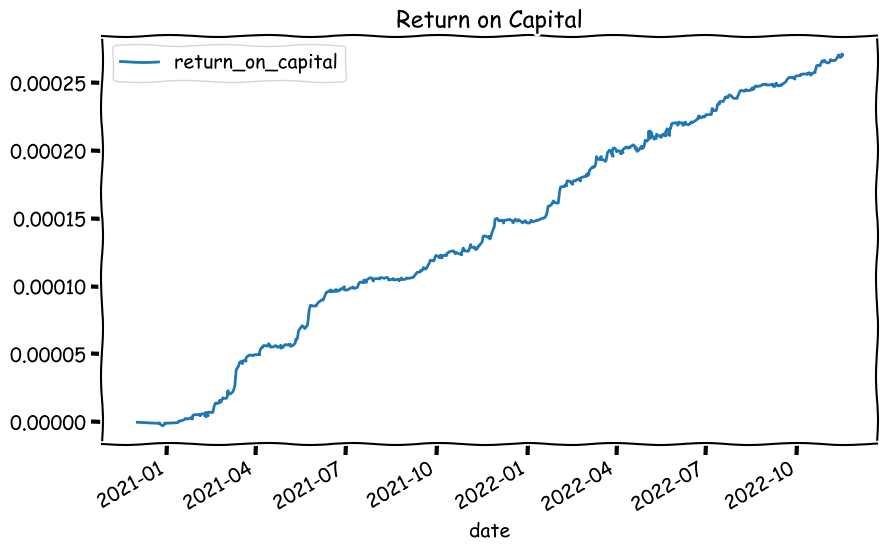

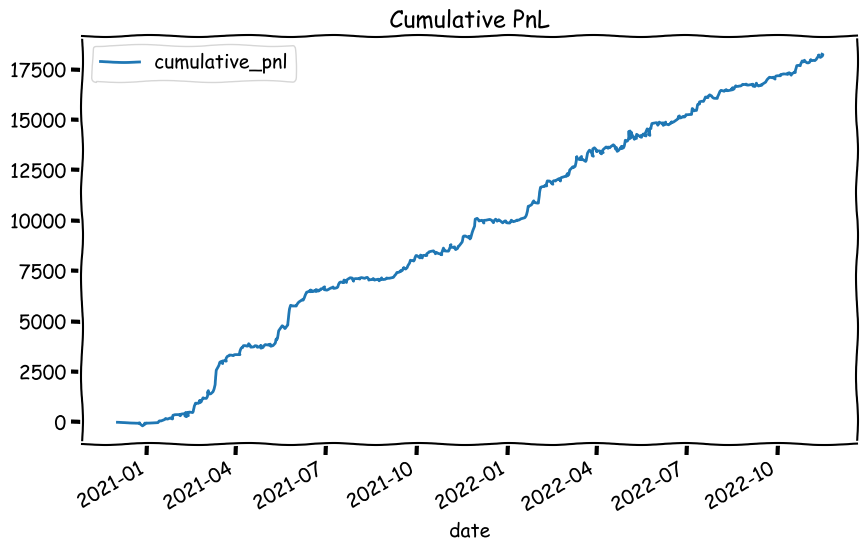

In [16]:
parameters1 = {'M':11,
              'g':0.00055,
              'j':-0.0004,
              's': 0.006}

df1 = return_spreads(df,etf_pairs,parameters1)

df_position1 = spread_trading(df1,etf_pairs,parameters1)
performance_metrics(df_position1,parameters1,returns_plot_show = True,pnl_plot_show = True)

* **M = 11, g = 0.00065, j = -0.0004, s = 0.0006**

,Mean,Vol,Sharpe,Min,Max,Max Drawdown
M:11_g:0.00065_j:-0.0004_s:0.0006,0.000111,0.000058,1.9064,-0.000002,0.000199,-0.000008


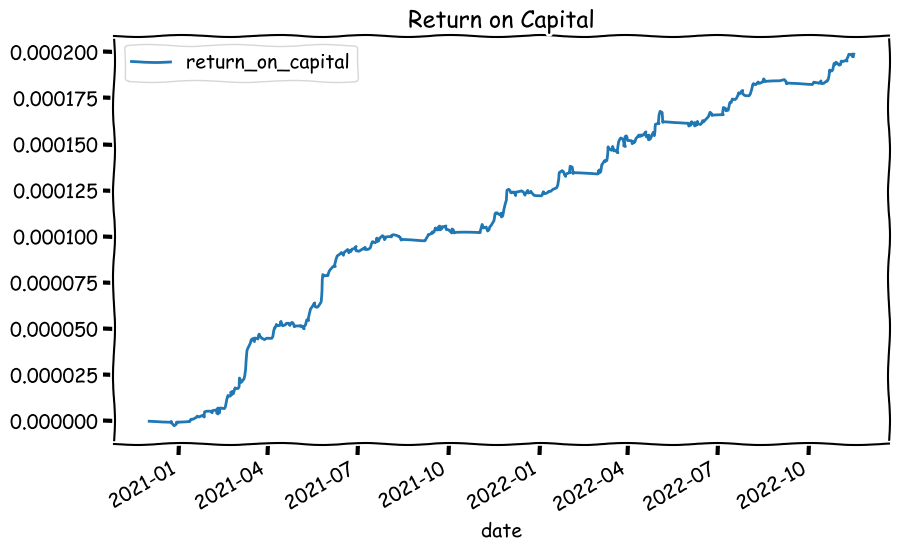

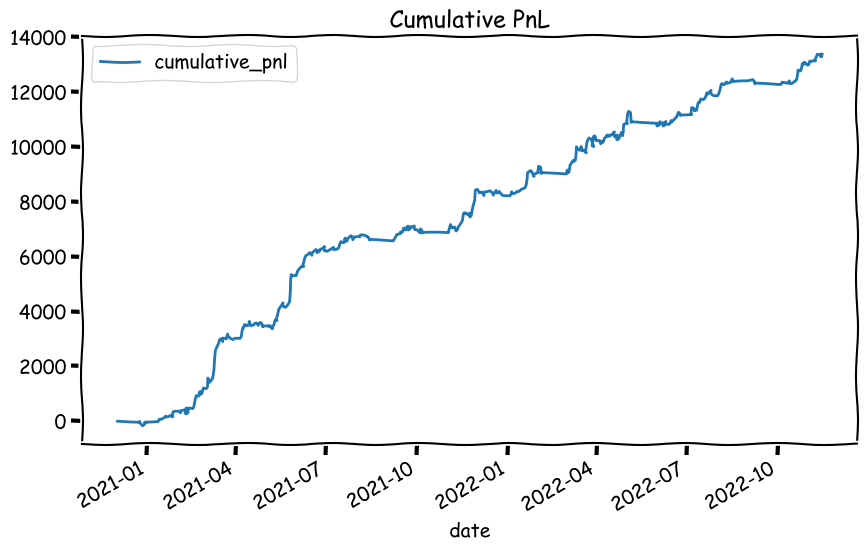

In [17]:
parameters2 = {'M':11,
              'g':0.00065,
              'j':-0.0004,
              's': 0.0006}

df2 = return_spreads(df,etf_pairs,parameters2)

df_position2 = spread_trading(df2,etf_pairs,parameters2)
performance_metrics(df_position2,parameters2,returns_plot_show = True, pnl_plot_show = True)

##### **Parameter discussions**

The above results are much better than I thought when I started to do this homework. 

When choosing the parameters **M = 11, g = 0.00055, j = -0.0004, s = 0.006**, the returns could achieve a Sharpe ratio of 1.7058, a maximum drawdown of -0.000006, a maximum return of 0.000271, and the cumulative PnL could reach 17500 by the end of the period. 

When choosing the parameters **M = 11, g = 0.00065, j = -0.0004, s = 0.0006**, the returns could achieve a Sharpe ratio of 1.9064, and a maximum drawdown of -0.000008.

As to how I got these sets of parameters, I firstly set M = 11 because it seems to be a reasonable choice. After using M = 11 to calculate the returns spread, I did a brief statistical analysis of returns spread, the result is as follows. 

**The returns spread fluctuates stably around 0, which is consistent with the assumption that the spread is expected to revert back to a comparatively stable average value.** Starting from setting g and j close to the maximum and minimum values of return spreads, after several attempts, I found that setting g and j close to the 75% and 25% quantile of the returns spreads could achieve the most satisfying results. The choice of s was also obtained by trying.

In [18]:
summary(df['return_spreads'].to_frame())

,Count,Mean,Standard deviation,Min,Max,VaR (0.05),Quantile 0.25,Median,Quantile 0.75,Skewness,Excess Kurtosis
return_spreads,493,0.000066,0.000822,-0.002525,0.002249,-0.001355,-0.000422,0.000045,0.000631,-0.139607,-0.077028


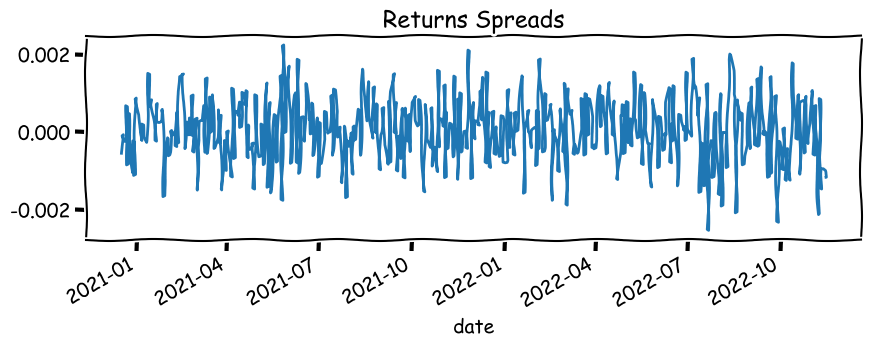

In [19]:
df['return_spreads'].plot(title="Returns Spreads",figsize = (10,3));

## Correlations to Fama French

I further looked into the correlations between PnL and Fama French factor returns.

#### Functions

In [20]:
def correlation_analysis(df_position,df_fama):
    
    df = df_position.join(df_fama).dropna()
    df = df[df.pnl != 0.0]
        
    df = df[['pnl_on_capital','Mkt-RF','SMB','HML','RF']]
        
    data = {'Mkt-RF': [df.corr()['pnl_on_capital']['Mkt-RF']],
            'SMB': [df.corr()['pnl_on_capital']['SMB']],
            'HML': [df.corr()['pnl_on_capital']['HML']]}
  
    df_corr = pd.DataFrame(data, index=['pnl_on_capital'])
    
    return df_corr

In [21]:
def ols_analysis(df_position,df_fama):
    
    df = df_position.join(df_fama).dropna()
    df = df[df.pnl != 0.0]
        
    df = df[['pnl_on_capital','Mkt-RF','SMB','HML']]
    
    y = df['pnl_on_capital']
    x = df[['Mkt-RF','SMB','HML']]
    
    x = sm.add_constant(x)
    
    model = sm.OLS(y, x).fit()
    
    print(model.summary())

#### Results

Use the two settings of parameters to obtain PnL and divide by capital. According to the below results, neither the correlation analysis with the three Fama French factors separately nor the OLS regression with the three factors together showed significant correlation to PnL of the spread trading strategy. 

* **M = 11, g = 0.00055, j = -0.0004, s = 0.006**

In [22]:
correlation_analysis(df_position1,df_fama)

,Mkt-RF,SMB,HML
pnl_on_capital,0.046617,0.031832,-0.057764


In [23]:
ols_analysis(df_position1,df_fama)

                            OLS Regression Results                            
Dep. Variable:         pnl_on_capital   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.7609
Date:                Thu, 19 Jan 2023   Prob (F-statistic):              0.516
Time:                        13:12:14   Log-Likelihood:                 5198.5
No. Observations:                 438   AIC:                        -1.039e+04
Df Residuals:                     434   BIC:                        -1.037e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.337e-07   8.21e-08      7.722      0.0

* **M = 11, g = 0.00065, j = -0.0004, s = 0.0006**

In [24]:
correlation_analysis(df_position2,df_fama)

,Mkt-RF,SMB,HML
pnl_on_capital,0.037446,0.091865,-0.11125


In [25]:
ols_analysis(df_position2,df_fama)

                            OLS Regression Results                            
Dep. Variable:         pnl_on_capital   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     2.187
Date:                Thu, 19 Jan 2023   Prob (F-statistic):             0.0895
Time:                        13:12:14   Log-Likelihood:                 3967.1
No. Observations:                 335   AIC:                            -7926.
Df Residuals:                     331   BIC:                            -7911.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.337e-07   9.71e-08      6.523      0.0

## Conclusion

This study implemented a trading strategy for returns spread of ETF pairs SIVR and SLV, achieved steadily increasing return on capital and cumulative PnL, and a best Sharpe ratio of 1.9064. 

The returns of the strategy didn't show a strong correlation with Fama French factors, that is, the returns could not be well explained by Fama French factors.